In [1]:
import random
import time
import numpy as np
import math 
import cv2
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO 
from typing import Callable
import os
import carla

2024-05-10 02:45:41.867356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 02:45:41.928501: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 02:45:42.245530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gp-coopperc/anaconda3/envs/Tensor/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cud

In [2]:
SECONDS_PER_EPISODE = 25
N_CHANNELS = 3
HEIGHT = 250
WIDTH = 250
FIXED_DELTA_SECONDS = 0.2
SHOW_PREVIEW = False

In [3]:
class CarEnv(gym.Env):
    SHOW_CAM = SHOW_PREVIEW
    STEER_AMT = 1.0
    im_width = WIDTH
    im_height = HEIGHT
    front_camera = None
    CAMERA_POS_Z = 1.3 
    CAMERA_POS_X = 1.4
    PREFERRED_SPEED = 60
    SPEED_THRESHOLD = 2
    
    def __init__(self):
        super(CarEnv, self).__init__()
        
        self.action_space = spaces.Discrete(9)

        self.observation_space = spaces.Box(low=0.0, high=255.0,
                                            shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(4.0)
        self.client.load_world('Town01')
        self.world = self.client.get_world()

        self.settings = self.world.get_settings()
        self.settings.no_rendering_mode = True
        self.settings.fixed_delta_seconds = FIXED_DELTA_SECONDS
        self.world.apply_settings(self.settings)
        self.blueprint_library = self.world.get_blueprint_library()
        self.model_3 = self.blueprint_library.filter("model3")[0]
        
    def maintain_speed(self, s):
        if s >= self.PREFERRED_SPEED:
            return 0
        elif s < self.PREFERRED_SPEED - self.SPEED_THRESHOLD:
            return 0.7
        else:
            return 0.3


        
    def reset(self, seed=None, options=None):
        self.collision_hist = []
        self.actor_list = []
        self.spawn_points = self.world.get_map().get_spawn_points()
        #print(type(self.spawn_points[2]))
        #print(type(random.choice(self.spawn_points)))
        
        print("Trying to spawn vehicle...")
        self.vehicle = self.world.try_spawn_actor(self.model_3, random.choice(self.spawn_points))
        if self.vehicle is None:
            print("Failed to spawn vehicle! Resetting environment...")
            self.cleanup()  # Clean up any existing actors
            return self.reset()  # Retry resetting the environment
        
        print("Vehicle spawned successfully!")
        
        self.actor_list.append(self.vehicle)
        self.initial_location = self.vehicle.get_location()
        self.sem_cam = self.blueprint_library.find('sensor.camera.semantic_segmentation')
        self.sem_cam.set_attribute("image_size_x", f"{self.im_width}")
        self.sem_cam.set_attribute("image_size_y", f"{self.im_height}")
        self.sem_cam.set_attribute("fov", f"90")


        camera_init_trans = carla.Transform(carla.Location(z=self.CAMERA_POS_Z,x=self.CAMERA_POS_X))
        self.sensor = self.world.spawn_actor(self.sem_cam, camera_init_trans, attach_to=self.vehicle)
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        time.sleep(2) #not detect a collision when the car spawns/falls from sky.
        # showing camera at the spawn point
        if self.SHOW_CAM:
            cv2.namedWindow('Sem Camera',cv2.WINDOW_AUTOSIZE)
            cv2.imshow('Sem Camera', self.front_camera)
            cv2.waitKey(1)
        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, camera_init_trans, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.front_camera is None:
            time.sleep(0.01)#Just in case car takes any longer, because we need to be certain the car is done falling from the sky on spawn.

        self.episode_start = time.time()
        #self.steering_lock = False
        #self.steering_lock_start = None # this is to count time in steering lock and start penalising for long time in steering lock
        self.step_counter = 0
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        
        observation = self.front_camera

        return observation.astype(np.uint8), {}
    
    def step(self, action):
        self.step_counter +=1
        steer = action
        # map steering actions
        if steer ==0:
            steer = - 0.9
        elif steer ==1:
            steer = -0.25
        elif steer ==2:
            steer = -0.1
        elif steer ==3:
            steer = -0.05
        elif steer ==4:
            steer = 0.0 
        elif steer ==5:
            steer = 0.05
        elif steer ==6:
            steer = 0.1
        elif steer ==7:
            steer = 0.25
        elif steer ==8:
            steer = 0.9


        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        estimated_throttle = self.maintain_speed(kmh)

        self.vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer, brake = 0.0))

        #distance_travelled = self.initial_location.distance(self.vehicle.get_location())

        # storing camera to return at the end in case the clean-up function destroys it
        cam = self.front_camera
        # showing image
        if self.SHOW_CAM:
            cv2.imshow('Sem Camera', cam)
            cv2.waitKey(1)

        # start defining reward from each step
        reward = 0
        done = False
        #punish for collision
        if len(self.collision_hist) != 0:
            done = True
            reward = reward - 300
            self.cleanup()
        #reward for acceleration
        if kmh < 15:
            reward = reward - 3
        elif kmh <25:
            reward = reward - 2
        elif kmh <50:
            reward = reward - 1
        elif kmh>120:
            reward = reward - 10 #punish for going too fast
        else:
            reward = reward + 1

        # check for episode duration
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            self.cleanup()
        
        observation = cam
        
        return observation.astype(np.uint8), reward, done, False, {}
        
    def cleanup(self):
        for actor in self.actor_list:
            if actor.is_alive:
                actor.destroy()
        #self.actor_list = []
        cv2.destroyAllWindows()

        
    def process_img(self, image):
        image.convert(carla.ColorConverter.CityScapesPalette)
        i = np.array(image.raw_data)
        i = i.reshape((self.im_height, self.im_width, 4))[:, :, :3] # this is to ignore the 4th Alpha channel - up to 3
        self.front_camera = i/255.0

    def collision_data(self, event):
        self.collision_hist.append(event)  

In [4]:
env = CarEnv()

model_name = "stable_baslines_randompoint"
models_dir = f"models/{model_name}/"

logdir = f"logs/{int(time.time())}/"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

model = PPO('CnnPolicy', env, verbose=1, learning_rate=0.001, tensorboard_log=logdir)

TIMESTEPS = 500_000
iters = 0

rewards = []
episode_num = 0

while iters < 4:
    iters += 1
    print('Iteration', iters, 'is to start...')
    try:
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f"PPO")
        print('Iteration', iters, 'has been trained')
        model.save(f"{models_dir}/{TIMESTEPS*iters}")
        # Store rewards for plotting
        episode_rewards = model.ep_info_buffer
        for ep_reward in episode_rewards:
            rewards.append((episode_num, ep_reward['r']))
            episode_num += 1
            
    except ValueError as e:
        print(f"Error during training iteration {iters}: {e}")
        continue

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Iteration 1 is to start...
Trying to spawn vehicle...
Vehicle spawned successfully!
Logging to logs/1715298344/PPO_0
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying

/home/gp-coopperc/anaconda3/envs/Tensor/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 115          |
|    ep_rew_mean          | -476         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 14           |
|    time_elapsed         | 645          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0013722387 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 4.23e+03     |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00204     |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 117        |
|    ep_rew_mean      

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 113          |
|    ep_rew_mean          | -465         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 23           |
|    time_elaps

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 103          |
|    ep_rew_mean          | -460         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 27           |
|    time_elaps

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 112          |
|    ep_rew_mean          | -477         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 31           |
|    time_elapsed         | 1430         |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0011936522 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.15        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 4.01e+03     |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00127     |
|    value_loss           | 6.31e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 123          |
|    ep_rew_mean          | -476         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 44           |
|    time_elapsed         | 2017         |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0018706019 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.13        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.001        |
|    loss                 | 4.49e+03     |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.002       |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 112         |
|    ep_rew_mean          | -454        |
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 53          |
|    time_elapsed         | 2428        |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.002616425 |
|    clip_fraction       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 108           |
|    ep_rew_mean          | -452          |
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 57            |
|    time_elapsed         | 2620          |
|    total_timesteps      | 116736        |
| train/                  |               |
|    approx_kl            | 0.00059446174 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.03         |
|    explained_variance   | 0             

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 111          |
|    ep_rew_mean          | -463         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 70           |
|    time_elapsed         | 3226         |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0027777748 |
|    clip_fraction        | 0            |
|    clip_range           | 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 109          |
|    ep_rew_mean          | -449         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 74           |
|    time_elapsed         | 3425         |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0009730478 |
|    clip_fraction        | 0            |
|    clip_range           | 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 106           |
|    ep_rew_mean          | -447          |
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 87            |
|    time_elapsed         | 4021          |
|    total_timesteps      | 178176        |
| train/                  |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 113          |
|    ep_rew_mean          | -451         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 91           |
|    time_elapsed         | 4204         |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0027309905 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.03        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.001        |
|    loss                 | 2.94e+03     |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.0025      |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 123          |
|    ep_rew_mean          | -452         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 100          |
|    time_elapsed         | 4596         |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0011697246 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.92        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.001        |
|    loss                 | 3.03e+03     |
|    n_updates            | 990          

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -452         |
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 109          |
|    time_elapsed         | 4970         |
|    total_timesteps      | 223232       |
| train/                  |              |
|    approx_kl            | 0.0023804584 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.89        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 2.4e+03      |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.00298     |
|    value_loss           | 5.31e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean   

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 126           |
|    ep_rew_mean          | -461          |
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 118           |
|    time_elapsed         | 5354          |
|    total_timesteps      | 241664        |
| train/                  |               |
|    approx_kl            | 0.00057717896 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.86         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.001         |
|    loss                 | 2.98e+03      |
|    n_updates            | 1170          |
|    policy_gradient_loss | -0.000648     |
|    value_loss           | 4.87e+03      |
-------------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 117          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_mean          | -458          |
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 127           |
|    time_elapsed         | 5741          |
|    total_timesteps      | 260096        |
| train/                  |               |
|    approx_kl            | 0.00040429426 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.88         |
|    explained_variance   | 1.79e-07      |
|    learning_rate        | 0.001         |
|    loss                 | 2.75e+03      |
|    n_updates            | 1260          |
|    policy_gradient_loss | -0.000565     |
|    value_loss           | 6.04e+03      |
------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 126         |
|    ep_rew_mean   

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean          | -448         |
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 141          |
|    time_elapsed         | 6317         |
|    total_timesteps      | 288768       |
| train/                  |              |
|    approx_kl            | 0.0012277754 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.001        |
|    loss                 | 2.22e+03     |
|    n_updates            | 1400         |
|    policy_gradient_loss | -0.00232     |
|    value_loss           | 4.56e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 126           |
|    ep_rew_mean          | -449          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 155           |
|    time_elapsed         | 6884          |
|    total_timesteps      | 317440        |
| train/                  |               |
|    approx_kl            | 0.00068950176 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.72         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 2.09e+03      |
|    n_updates            | 1540          |
|    policy_gradient_loss | -0.00107      |
|    value_loss           | 3.71e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -447         |
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 164          |
|    time_elapsed         | 7264         |
|    total_timesteps      | 335872       |
| train/                  |              |
|    approx_kl            | 0.0004452194 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 111           |
|    ep_rew_mean          | -440          |
| time/                   |               |
|    fps                  | 46         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 125          |
|    ep_rew_mean          | -447         |
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 182          |
|    time_elapsed         | 8038         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0001211442 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 2e+03        |
|    n_updates            | 1810         |
|    policy_gradient_loss | -0.00018     |
|    value_loss           | 4.68e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 123           |
|    ep_rew_mean          | -440          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 191           |
|    time_elapsed         | 8413          |
|    total_timesteps      | 391168        |
| train/                  |               |
|    approx_kl            | 0.00071053125 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.001         |
|    loss                 | 2.78e+03      |
|    n_updates            | 1900          |
|    policy_gradient_loss | -0.0015  

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 117         |
|    ep_rew_mean          | -432        |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 200         |
|    time_elapsed         | 8799        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.000990386 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explaine

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 121          |
|    ep_rew_mean          | -447         |
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 209          |
|    time_elapsed         | 9182         |
|    total_timesteps      | 428032       |
| train/                  |              |
|    approx_kl            | 0.0012994905 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 137           |
|    ep_rew_mean          | -463          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 134          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_mean          | -457          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 228           |
|    time_elapsed         | 9947          |
|    total_timesteps      | 466944        |
| train/                  |               |
|    approx_kl            | 0.00045243464 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.83         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 1.23e+03      |
|    n_updates            | 2270          |
|    policy_gradient_loss | -0.000636     |
|    value_loss           | 3.62e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | -452         |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 233          |
|    time_elapsed         | 10135        |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0012710937 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 119           |
|    ep_rew_mean          | -442          |
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 242           |
|    time_elapsed         | 10528         |
|    total_timesteps      | 495616        |
| train/                  |               |
|    approx_kl            | 0.00031123016 |
|    clip_fraction        | 0             |
|    clip_range 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -453         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 6            |
|    time_elapsed         | 244          |
|    total_timesteps      | 514048       |
| train/                  |              |
|    approx_kl            | 0.0011382597 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.85        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 2.27e+03     |
|    n_updates            | 2500         |
|    policy_gradient_loss | -0.00123     |
|    value_loss           | 2.75e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -451         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | -444        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 15          |
|    time_elapsed         | 617         |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.001457785 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 1.17e+03    |
|    n_updates            | 2590        |
|    policy_gradient_loss | -0.00106    |
|    value_loss           | 2.95e+03    |
-----------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Tryi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 136          |
|    ep_rew_mean          | -449         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 116           |
|    ep_rew_mean          | -435          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 29            |
|    time_elapsed         | 1211          |
|    total_timesteps      | 561152        |
| train/                  |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 133           |
|    ep_rew_mean          | -455          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_mean          | -444          |
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 43            |
|    time_elapsed         | 1801          |
|    total_timesteps      | 589824        |
| train/                  |               |
|    approx_kl            | 0.00023731255 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.66         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss  

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 125         |
|    ep_rew_mean          | -442        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 52          |
|    time_elapsed         | 2165        |
|    total_timesteps      | 608256      |
| train/                  |             |
|    approx_kl            | 0.001275169 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0           |
|    learning_rate        | 0.001       |
|    loss                 | 1.28e+03    |
|    n_updates            | 2960        |
|    policy_gradient_loss | -0.00138    |
|    value_loss           | 2.68e+03    |
-----------------------------------------
Tryi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -441         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 57           |
|    time_elaps

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 127           |
|    ep_rew_mean          | -449          |
| time/                   |               |
|    fps                  | 49         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 123           |
|    ep_rew_mean          | -443          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 71            |
|    time_elapsed         | 2931          |
|    total_timesteps      | 647168        |
| train/                  |               |
|    approx_kl            | 0.00035330976 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.56         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 731           |
|    n_updates            | 3150          |
|    policy_gradient_loss | -0.000459

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 121          |
|    ep_rew_mean          | -450         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 80           |
|    time_elapsed         | 3303         |
|    total_timesteps      | 665600       |
| train/                  |              |
|    approx_kl            | 0.0003084745 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.57        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 121           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 134          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 131           |
|    ep_rew_mean          | -451          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 99            |
|    time_elapsed         | 4079          |
|    total_timesteps      | 704512        |
| train/                  |               |
|    approx_kl            | 0.00010668306 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.63         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.001         |
|    loss                 | 1.07e+03      |
|    n_updates            | 3430          |
|    policy_gradient_loss | -9.09e-05     |
|    value_loss           | 2.05e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 133           |
|    ep_rew_mean          | -451          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 104           |
|    tim

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean          | -438         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 118          |
|    time_elapsed         | 4856         |
|    total_timesteps      | 743424       |
| train/                  |              |
|    approx_kl            | 3.204742e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.72        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.001        |
|    loss                 | 1.94e+03     |
|    n_updates            | 3620         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 142          |
|    ep_rew_mean          | -447         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 125           |
|    ep_rew_mean          | -445          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 132           |
|    time_elapsed         | 5420          |
|    total_timesteps      | 772096        |
| train/                  |               |
|    approx_kl            | 0.00017349623 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 1.72e+03      |
|    n_updates            | 3760          |
|    policy_gradient_loss | -0.000375

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -441        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 141         |
|    time_elapsed         | 5813        |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.002678825 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.001       |
|    loss                 | 1.07e+03    |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 133          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 139           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 123          |
|    ep_rew_mean          | -448         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 155          |
|    time_elapsed         | 6376         |
|    total_timesteps      | 819200       |
| train/                  |              |
|    approx_kl            | 0.0007635049 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 1.14e+03     |
|    n_updates            | 3990         |
|    policy_gradient_loss | -0.0013      |
|    value_loss           | 1.81e+03     |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -443         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 164          |
|    time_elapsed         | 6757         |
|    total_timesteps      | 837632       |
| train/                  |              |
|    approx_kl            | 8.671588e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 1.05e+03     |
|    n_updates            | 4080         |
|    policy_gradient_loss | -0.000297    |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 130           |
|    ep_rew_mean          | -447          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 169           |
|    tim

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 132           |
|    ep_rew_mean          | -453          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 178           |
|    time_elapsed         | 7319          |
|    total_timesteps      | 866304        |
| train/                  |               |
|    approx_kl            | 0.00026211573 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.6          |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 581           |
|    n_updates            | 4220          |
|    policy_gradient_loss | -0.00046      |
|    value_loss           | 1.24e+03      |
-------------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 131          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 132           |
|    ep_rew_mean          | -455          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 192           |
|    time_elapsed         | 7901          |
|    total_timesteps      | 894976        |
| train/                  |               |
|    approx_kl            | 1.7682556e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.48         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 846           |
|    n_updates            | 4360          |
|    policy_gradient_loss | -0.000109

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean          | -454         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 201          |
|    time_elapsed         | 8281         |
|    total_timesteps      | 913408       |
| train/                  |              |
|    approx_kl            | 0.0005114542 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.52        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 861          |
|    n_updates            | 4450         |
|    policy_gradient_loss | -0.000925    |
|    value_loss           | 1.33e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 113           |
|    ep_rew_mean          | -446          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 123           |
|    ep_rew_mean          | -438          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 219           |
|    time_elapsed         | 9059          |
|    total_timesteps      | 950272        |
| train/                  |               |
|    approx_kl            | 3.3884164e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 125           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 118         |
|    ep_rew_mean          | -443        |
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 228         |
|    time_elapsed         | 9446        |
|    total_timesteps      | 968704      |
| train/                  |             |
|    approx_kl            | 0.005656492 |
|    clip_fraction        | 0.00854     |
|    clip_range           | 0.2         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 141         |
|    ep_rew_mean          | -456        |
| time/                   |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 123          |
|    ep_rew_mean          | -449         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 237          |
|    time_elapsed         | 9809         |
|    total_timesteps      | 987136       |
| train/                  |              |
|    approx_kl            | 9.813919e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.001        |
|    loss                 | 557          |
|    n_updates            | 4810         |
|    policy_gradient_loss | -0.000259    |
|    value_loss           | 1.57e+03     |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 130          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 133      |
|    ep_rew_mean     | -443     |
| time/              |          |
|    fps             | 46       |
|    iterations      | 1        |
|    time_elapsed    | 43       |
|    total_timesteps | 1005568  |
---------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicl

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | -459         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 16           |
|    time_elapsed         | 646          |
|    total_timesteps      | 1036288      |
| train/                  |              |
|    approx_kl            | 0.0006955773 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.53        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 534          |
|    n_updates            | 5050         |
|    policy_gradient_loss | -0.0012      |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 135          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 120           |
|    ep_rew_mean          | -442          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 25            |
|    time_elapsed         | 1015          |
|    total_timesteps      | 1054720       |
| train/                  |               |
|    approx_kl            | 6.1270985e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.45         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 940           |
|    n_updates            | 5140          |
|    policy_gradient_loss | -0.000406     |
|    value_loss           | 1.36e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 117           |
|    ep_rew_mean          | -443          |
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 34            |
|    time_elapsed         | 1404          |
|    total_timesteps      | 1073152       |
| train/                  |               |
|    approx_kl            | 2.6349066e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 136          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 134           |
|    ep_rew_mean          | -445          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 48            |
|    time_elapsed         | 1959          |
|    total_timesteps      | 1101824       |
| train/                  |               |
|    approx_kl            | 0.00014176461 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.58         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 624           |
|    n_updates            | 5370          |
|    policy_gradient_loss | -0.000334     |
|    value_loss           | 1.34e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -439         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 62           |
|    time_elapsed         | 2533         |
|    total_timesteps      | 1130496      |
| train/                  |              |
|    approx_kl            | 0.0019024567 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 582          |
|    n_updates            | 5510         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 1.35e+03     |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 128            |
|    ep_re

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 131           |
|    ep_rew_mean          | -450          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 127           |
|    ep_rew_mean          | -445          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 81            |
|    time_elapsed         | 3303          |
|    total_timesteps      | 1169408       |
| train/                  |               |
|    approx_kl            | 0.00036694255 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.48         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.001         |
|    loss                 | 524           |
|    n_updates            | 5700          |
|    policy_gradient_loss | -0.000929     |
|    value_loss           | 972           |
------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 126          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | -444         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 90           |
|    time_elapsed         | 3671         |
|    total_timesteps      | 1187840      |
| train/                  |              |
|    approx_kl            | 0.0014138072 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.46        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.001        |
|    loss                 | 704          |
|    n_updates            | 5790         |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 1.02e+03     |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 126           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 122          |
|    ep_rew_mean          | -442         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 99           |
|    time_elapsed         | 4054         |
|    total_timesteps      | 1206272      |
| train/                  |              |
|    approx_kl            | 0.0010840558 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 129           |
|    ep_rew_mean          | -446          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | -456         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 113          |
|    time_elapsed         | 4626         |
|    total_timesteps      | 1234944      |
| train/                  |              |
|    approx_kl            | 0.0011723656 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.001        |
|    loss                 | 587          |
|    n_updates            | 6020         |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 938          |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 137           |
|    ep_rew_mean          | -468          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 118           |
|    time_elapsed         | 4816          |
|    total_timesteps      | 1245184       |
| train/                  |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 134           |
|    ep_rew_mean          | -444          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 127           |
|    time_elapsed         | 5176          |
|    total_timesteps      | 1263616       |
| train/                  |               |
|    approx_kl            | 0.00078268355 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.48         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 381           |
|    n_updates            | 6160          |
|    policy_gradient_loss | -0.0012       |
|    value_loss           | 1.09e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 133          |
|    ep_rew_mean          | -456         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 146           |
|    ep_rew_mean          | -457          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 137           |
|    time_elapsed         | 5554          |
|    total_timesteps 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 132          |
|    ep_rew_mean          | -438         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 120           |
|    ep_rew_mean          | -432          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 151           |
|    time_elapsed         | 6131          |
|    total_timesteps      | 1312768       |
| train/                  |               |
|    approx_kl            | 0.00043344463 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.38         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 451           |
|    n_updates            | 6400          |
|    policy_gradient_loss | -0.000269

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 126            |
|    ep_rew_mean          | -447           |
| time/                   |                |
|    fps                  | 50             |
|    iterations           | 165            |
|    time_elapsed         | 6699           |
|    total_timesteps      | 1341440        |
| train/                  |                |
|    approx_kl            | 0.000120864745 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.32          |
|    explained_variance   | 1.19e-07       |
|    learning_rate        | 0.001          |
|    loss                 | 459            |
|    n_updates            | 6540           |
|    policy_gradient_loss | -0.000288      |
|    value_loss           | 1.04e+03       |
-------------------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 123           |
|    ep_rew_mean          | -438          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 174           |
|    time_elapsed         | 7085          |
|    total_timesteps      | 1359872       |
| train/                  |               |
|    approx_kl            | 7.4587064e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.32         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 465           |
|    n_updates            | 6630          |
|    policy_gradient_loss | -8.5e-05 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_rew_mean          | -437         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 132           |
|    ep_rew_mean          | -450          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 183           |
|    time_elapsed         | 7458          |
|    total_timesteps      | 1378304       |
| train/                  |               |
|    approx_kl            | 0.00062805956 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.4          |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 402           |
|    n_updates            | 6720          |
|    policy_gradient_loss | -0.000559     |
|    value_loss           | 1.03e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 136           |
|    ep_rew_mean          | -445          |
| time/                   |               |
|    fps                  | 50         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | -438         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 133          |
|    ep_rew_mean

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 124           |
|    ep_rew_mean          | -438          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 212           |
|    time_elapsed         | 8611          |
|    total_timesteps      | 1437696       |
| train/                  |               |
|    approx_kl            | 0.00021720718 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.37         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 482           |
|    n_updates            | 7010          |
|    policy_gradient_loss | -0.000382     |
|    value_loss           | 857           |
------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 121           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 132           |
|    ep_rew_mean          | -437          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 226           |
|    time_elapsed         | 9175          |
|    total_timesteps      | 1466368       |
| train/                  |               |
|    approx_kl            | 0.00011443015 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.44         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 489           |
|    n_updates            | 7150          |
|    policy_gradient_loss | -0.000208     |
|    value_loss           | 1.08e+03      |
-------------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 140          |
|    ep_rew_mean          | -442         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 231          |
|    time_elapsed         | 9365         |
|    total_timesteps      | 1476608      |
| train/                  |              |
|    approx_kl            | 0.0009188172 |
|    clip_frac

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 154           |
|    ep_rew_mean          | -448          |
| time/                   |               |
|    fps                  | 50            |
|    iterations           | 236           |
|    time_elapsed         | 9542          |
|    total_timesteps      | 1486848       |
| train/                  |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 147          |
|    ep_rew_mean          | -436         |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 241          |
|    time_elaps

Iteration 3 has been trained
Iteration 4 is to start...
Logging to logs/1715298344/PPO_0
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | -435        |
| time/                   |             |
|    fps                  | 51          |
|    it

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 127           |
|    ep_rew_mean          | -447          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 15            |
|    time_elapsed         | 597           |
|    total_timesteps      | 1536000       |
| train/                  |               |
|    approx_kl            | 0.00021286556 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.48         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.001         |
|    loss                 | 301           |
|    n_updates            | 7490          |
|    policy_gradient_loss | -0.000325

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 141          |
|    ep_rew_mean          | -462         |
| time/                   |              |
|    fps                  | 52           |
|    iterations           | 20           |
|    time_elapsed         | 781          |
|    total_timesteps      | 1546240      |
| train/                  |              |
|    approx_kl            | 0.0002754274 |
|    clip_fraction        | 0            |
|    clip_range           | 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 131           |
|    ep_rew_mean          | -452          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 34            |
|    time_elapsed         | 1346          |
|    total_timesteps      | 1574912       |
| train/                  |               |
|    approx_kl            | 0.00013139428 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.52         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.001         |
|    loss                 | 902           |
|    n_updates          

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 137          |
|    ep_rew_mean          | -450         |
| time/                   |              |
|    fps                  | 52           |
|    iterations           | 39           |
|    time_elapsed         | 1528         |
|    total_timesteps      | 1585152      |
| train/                  |              |
|    approx_kl            | 0.0006496031 |
|    clip_frac

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 135           |
|    ep_rew_mean          | -433          |
| time/                   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 128           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |


Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 126          |
|    ep_rew_mean          | -428         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 63           |
|    time_elapsed         | 2492         |
|    total_timesteps      | 1634304      |
| train/                  |              |
|    approx_kl            | 0.0003275308 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 390          |
|    n_updates            | 7970         |
|    policy_gradient_loss | -0.000801    |
|    value_l

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 135           |
|    ep_rew_mean          | -434          |
| time/                   |               |
|    fps                  | 51         

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 138           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 142          |
|    ep_rew_mean          | -446         |
| time/                   |              |
|    fps                  | 52           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 125           |
|    ep_rew_mean          | -437          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 92            |
|    time_elapsed         | 3643          |
|    total_timesteps      | 1693696       |
| train/                  |               |
|    approx_kl            | 0.00035952652 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.54         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 491           |
|    n_updates            | 8260          |
|    policy_gradient_loss | -0.000402     |
|    value_loss           | 1.03e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 138           |
|    ep_rew_mean          | -441          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 97            |
|    tim

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 119            |
|    ep_rew_mean          | -439           |
| time/                   |                |
|    fps                  | 51             |
|    iterations           | 106            |
|    time_elapsed         | 4223           |
|    total_timesteps      | 1722368        |
| train/                  |                |
|    approx_kl            | 0.000121609424 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.52          |
|    explained_variance   | 0              |
|    learning_rate        | 0.001       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 134          |
|    ep_rew_mean          | -448         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 133          |
|    ep_rew_mean          | -445         |
| time/                   |              |
|    fps                  | 51           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 121           |
|    ep_rew_mean          | -432          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 130           |
|    time_elapsed         | 5179          |
|    total_timesteps      | 1771520       |
| train/                  |               |
|    approx_kl            | 0.00012178402 |
|    clip_fraction        | 0             |
|    clip_range 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | -428         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 135          |
|    time_elaps

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 131           |
|    ep_rew_mean          | -440          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 139           |
|    time_elapsed         | 5532          |
|    total_timesteps      | 1789952       |
| train/                  |               |
|    approx_kl            | 4.0718558e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.51         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.001         |
|    loss                 | 289           |
|    n_updates            | 8730          |
|    policy_gradient_loss | -8.13e-05     |
|    value_loss           | 1.1e+03       |
-------------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
| 

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 122           |
|    ep_rew_mean          | -436          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 153           |
|    time_elapsed         | 6107          |
|    total_timesteps      | 1818624       |
| train/                  |               |
|    approx_kl            | 0.00089137245 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss                 | 458           |
|    n_updates            | 8870          |
|    policy_gradient_loss | -0.00056      |
|    value_loss           | 1.06e+03      |
-------------------------------------------
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 131           |
|    ep_rew_mean          | -442          |
| time/                   

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 128           |
|    ep_rew_mean          | -433          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 162           |
|    time_elapsed         | 6476          |
|    total_timesteps      | 1837056       |
| train/                  |               |
|    approx_kl            | 0.00019734181 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.44         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.001         |
|    loss                 | 474           |
|    n_updates            | 8960          |
|    policy_gradient_loss | -0.00041      |
|    value_loss           | 1.05e+03      |
-------------------------------------------
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn veh

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 139          |
|    ep_rew_mean          | -441         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 167          |
|    time_elapsed         | 6662         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0002431281 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 134          |
|    ep_rew_mean          | -431         |
| time/                   |              |
|    fps                  | 51           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 120          |
|    ep_rew_mean          | -432         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 176          |
|    time_elapsed         | 7037         |
|    total_timesteps      | 1865728      |
| train/                  |              |
|    approx_kl            | 0.0010329923 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 172          |
|    n_updates            | 9100         |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 980          |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 140           |
|    ep_rew_mean          | -445          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 181           |
|    time_elapsed         | 7226          |
|    total_timesteps      | 1875968       |
| train/                  |       

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehi

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 136          |
|    ep_rew_mean          | -434         |
| time/                   |              |
|    fps                  | 51           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 142           |
|    ep_rew_m

Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 129          |
|    ep_rew_mean          | -434         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 200          |
|    time_elapsed         | 7986         |
|    total_timesteps      | 1914880      |
| train/                  |              |
|    approx_kl            | 6.786498e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 486          |
|    n_updates            | 9340         |
|    policy_gradient_loss | -1.11e-05    |
|    value_loss           | 1.11e+03     |
------------------------------------------
Trying to spawn vehicle...
Vehicle spawn

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 136           |
|    ep_rew_mean          | -437          |
| time/                   |               |
|    fps                  | 51            |
|    iterations           | 205           |
|    time_elapsed         | 8168          |
|    total_timesteps      | 1925120       |
| train/                  |               |
|    approx_kl            | 0.00028183396 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.4          |
|    explained_variance   | 0             |
|    learning_rate        | 0.001         |
|    loss  

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 153          |
|    ep_rew_mean          | -462         |
| time/                   |              |
|    fps                  | 51           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 140          |
|    ep_rew_mean          | -453         |
| time/                   |              |
|    fps                  | 51           |
|

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | -432         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 224          |
|    time_elapsed         | 8921         |
|    total_timesteps      | 1964032      |
| train/                  |              |
|    approx_kl            | 0.0005722219 |
|    clip_frac

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-------------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -428         |
| time/                   |              |
|    fps                  | 51           |
|    iterations           | 233          |
|    time_elapsed         | 9294         |
|    total_timesteps      | 1982464      |
| train/                  |              |
|    approx_kl            | 0.0013213493 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.44        |
|    explained_variance   | 0            |
|    learning_rate        | 0.001        |
|    loss                 | 844          |
|    n_updates            | 9670         |
|    policy_gradient_loss | -0.00089     |
|    value_loss           | 956          |
--------------------------

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 139          |
|    ep_rew_mean          | -437         |
| time/                   |   

Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
Trying to spawn vehicle...
Vehicle spawned successfully!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | -448        |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 243         |
|    time_elapsed     

NameError: name 'plt' is not defined

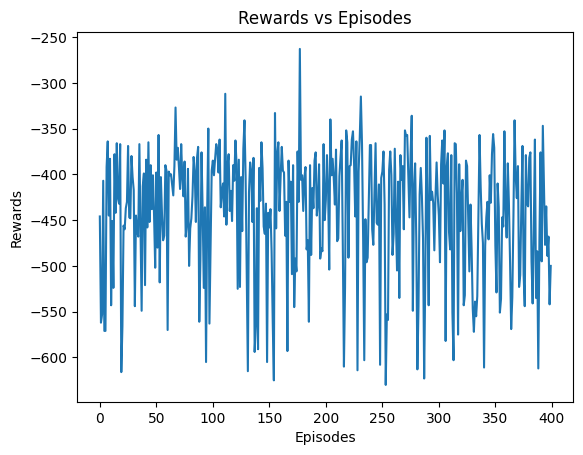

In [5]:
# Plot rewards
import matplotlib.pyplot as plt
episodes, rewards_list = zip(*rewards)
plt.plot(episodes, rewards_list)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards vs Episodes')
plt.show()